Group : Abraham, Avani, Apoorva, Alyson, Jefrey                                         
* Run on Python 2

### 1 / 2

In [ ]:
# Web scraper for Edmunds
# Selenium is used to handle the javascript on a website

#Importing libraries
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import re
import pandas as pd
import os     #to manipulate files



In [ ]:
chrome_path = r'C:\Users\Abraham\Downloads\Apps\chromedriver'
# prepend it with r because of the backslash characters

driver = webdriver.Chrome(chrome_path) # This will open up a chrome window

page = 2557
url = "https://forums.edmunds.com/discussion/18576/general/x/edmunds-members-cars-conversations/p" + str(page)

driver.get(url)  # Open that website


In [ ]:
userlist = []
datelist = []
postlist = []
quotelist = []
while len(postlist)<5000:
    #User
    users = driver.find_elements_by_class_name('Username')
    for user in users:
        userlist.append(user.text)
    
    #Date
    dates = driver.find_elements_by_class_name('DateCreated')
    for date in dates:
        datelist.append(date.text)
    
    # This is the list of all the comments
    posts = driver.find_elements_by_class_name('Item-Body')
    for post in posts:
        postlist.append(post.text)

    # This is the list of the blockquotes that you don't want
    quotes = driver.find_elements_by_class_name('Quote')
    for quote in quotes:
        quotelist.append(quote.text)
        
    page = page - 1
    url = "https://forums.edmunds.com/discussion/18576/general/x/edmunds-members-cars-conversations/p" + str(page)

    driver.get(url)
    


In [ ]:
# Now you have to delete quotes from the posts
for j in range(0,len(quotelist)):
    for i in range(0,len(postlist)):
        if (quotelist[j] in postlist[i]):
            postlist[i]=postlist[i].replace(quotelist[j],'')   

In [ ]:
len(postlist)

In [ ]:
df_raw = pd.DataFrame(datelist)
df_raw['Users'] = userlist
df_raw['Text'] = postlist
df_raw.columns = ['Date','User','Text']

In [ ]:
df_raw

In [ ]:
postfile_name = r'C:\Users\Abraham\MSBA\Text\HW2\postfile.csv'
df_raw.to_csv(postfile_name)

# 3

In [1]:
import pandas as pd
posts=pd.read_csv('postfile.csv')

In [2]:
posts = posts.replace(r'\n',' ', regex=True)
posts = posts.replace(r'\r',' ', regex=True)
posts.head(2)

,Unnamed: 0,Date,User,Text
0,0,Sep-26,snakeweasel,I went and checked and yes the 59k one is an...
1,1,Sep-26,snakeweasel,I would have told them that I used to but I ...


In [3]:
import nltk
import re
from nltk.tokenize import sent_tokenize, word_tokenize

### 3 Task A

In [4]:
from string import punctuation
def unique_words(s):
# Remove punctuation & others, convert to lower and finally stopwords
    s=str(s)
    for p in punctuation:
        s =s.replace(p,'')
    s=s.lower()
    return list(set(re.findall('\w+',s)))

posts['unique_words_list']=posts['Text'].map(unique_words)

In [5]:
posts[:5]

,Unnamed: 0,Date,User,Text,unique_words_list
0,0,Sep-26,snakeweasel,I went and checked and yes the 59k one is an...,"[and, the, hyundai, checked, ctx700d, 2015, i,..."
1,1,Sep-26,snakeweasel,I would have told them that I used to but I ...,"[because, sonata, have, sebring, ragtop, would..."
2,2,Sep-26,bwia,"No, it can't be otherwise the transactions w...","[secure, is, africa, it, cant, in, even, slow,..."
3,3,Sep-26,Mr_Shiftright,stickguy said: function is not reliability. S...,"[and, alfa, help, just, is, share, satisfactio..."
4,4,Sep-26,imidazol97,show previous quotes I would have tol...,"[because, golf, show, cobalt, back, nascar, ye..."


In [6]:
# Mapping  to brand
car_mapping=pd.read_csv('car-list.csv')
def lowering (s):
    s=s.rstrip()
    return s.lower()
car_mapping['model']=car_mapping['model'].map(lowering)
car_mapping['brand']=car_mapping['brand'].map(lowering)

In [7]:
def mentioned_brands(list_1):
    list_i=pd.DataFrame(list_1)
    mask=car_mapping['model'].isin(pd.Series(list_1))
    joiner=car_mapping[mask]
    joined=joiner.merge(list_i, left_on='model', right_on=0)
    out=set(list(joined['brand']))
    return list(out)

posts['unique_brands']=posts['unique_words_list'].map(mentioned_brands)


In [8]:
unique_brands_superlist=posts['unique_brands'].sum()
unique_brands=nltk.FreqDist(unique_brands_superlist)
unique_brands=pd.DataFrame.from_dict(unique_brands, orient='index', columns=['freq']).sort_values(by='freq', ascending=False)

In [9]:
unique_brands[:10].plot(kind='bar')

In [10]:
import numpy as np
from itertools import combinations, groupby
from collections import Counter

# Sample data
unique_brands_list = list(unique_brands.index.values)
def combination_of_2(set):
    return list(combinations(set,2))

posts['combinations_of_2']=posts['unique_brands'].map(combination_of_2)
set_of_1=posts['unique_brands'].sum()
set_of_2=posts['combinations_of_2'].sum()

from collections import Counter
count_1s=Counter(set_of_1)
count_2s=Counter(set_of_2)

In [11]:
unique_name=unique_brands.index.values
matrix = pd.DataFrame(index=unique_name, columns=unique_name)
for row in unique_name:
       for column in unique_name:
            if row==column:
                matrix.loc[row,column]=0
            else:
                matrix.loc[row,column]=((count_2s[(row, column)]+count_2s[(column, row)])*len(posts)*1.0)/(count_1s[row]*count_1s[column]*1.0)
matrix.iloc[:14,:14]

,mercedes-benz,lexus,hyundai,mazda,peugeot,chrysler,ford,volkswagen,audi,honda,nissan,subaru,chevrolet,infiniti
mercedes-benz,0,1.20131,0.875713,1.2328,0.879591,0.892423,1.09071,1.32481,1.23067,1.04619,1.2462,1.11577,1.05404,1.09714
lexus,1.20131,0,0.82295,1.35091,0.870306,0.915564,1.16728,1.60099,1.60191,1.06228,1.22975,1.09538,0.934913,0.982689
hyundai,0.875713,0.82295,0,1.70717,2.79701,3.3067,0.246798,0.508367,0.336052,0.328163,0.367401,3.37878,0.34701,0.422033
mazda,1.2328,1.35091,1.70717,0,0.68054,0.69005,1.14554,1.78412,1.78023,1.30274,0.974475,4.3446,1.01727,1.0261
peugeot,0.879591,0.870306,2.79701,0.68054,0,4.22389,0.287579,0.511005,2.25809,0.422641,2.47854,0.117609,5.45705,0.310592
chrysler,0.892423,0.915564,3.3067,0.69005,4.22389,0,4.09912,0.44013,0.405892,0.453152,0.459018,0.281869,0.310056,0.279145
ford,1.09071,1.16728,0.246798,1.14554,0.287579,4.09912,0,0.973444,0.941199,0.903987,0.704376,0.625015,0.698546,0.647293
volkswagen,1.32481,1.60099,0.508367,1.78412,0.511005,0.44013,0.973444,0,4.40647,1.6874,0.594519,2.09463,0.736998,1.70731
audi,1.23067,1.60191,0.336052,1.78023,2.25809,0.405892,0.941199,4.40647,0,0.907745,4.77262,0.63992,0.63992,0.855039
honda,1.04619,1.06228,0.328163,1.30274,0.422641,0.453152,0.903987,1.6874,0.907745,0,0.569352,1.29678,1.08065,6.59959


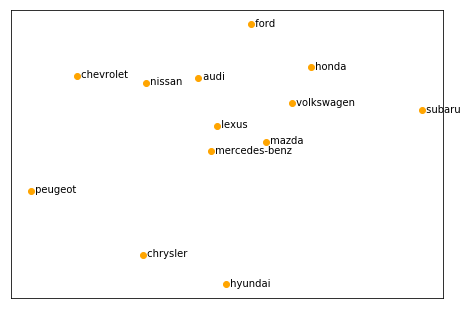

In [12]:
matrix_1=matrix.iloc[:13,:13]
matrix_1=matrix_1.replace(np.nan,0)

import numpy as np
from sklearn import manifold
from sklearn.manifold import MDS

mdsdf = 1/matrix_1

mdsdf=mdsdf.replace(np.nan,0)
mdsdf=mdsdf.replace(np.inf,0)

mdsmatrix=mdsdf.values

from matplotlib import pyplot as plt

mds=manifold.MDS(n_components=2, dissimilarity ='precomputed', random_state=10)

results=mds.fit(mdsmatrix)
coords=results.embedding_

x=coords[:,0]
y=coords[:,1]

ax=plt.axes([0.,0.,1.,1.])
plt.scatter(x,y,marker='o',color='orange')

n=list(mdsdf.index)

for i,n in enumerate(n):
    #print(x[i].item())
    #print(n)
    #print(type(y[i]))
    if n=='kia':
        ax.annotate(n,xy=((x[i]+.01),y[i]-.01))
    else:
        ax.annotate(n,xy=((x[i]+.01),y[i]-.02))

plt.xticks([])
plt.yticks([])

plt.show()

### Task B

As per our analysis, Mercedes-Benz is facing a really tough competition from Lexus. Despite of the fact that they are perceived to be playing in very different league. Another interesting fact is appearance of Mazda really close to these brands which is unexpected as it isn't a premiere league car. BMW is appearing really far away from all of these which is strange again as these are perceived to be equivalent brands 

### Task C

In [13]:
unique_brands_superlist=posts['unique_brands'].sum()
top_5_brands=unique_brands[:5]
car_mapping1=car_mapping.merge(top_5_brands,left_on='brand',right_index=True,how='inner')
def mentioned_topbrands(list_1):
    list_i=pd.DataFrame(list_1)
    mask=car_mapping1['model'].isin(pd.Series(list_1))
    joiner=car_mapping1[mask]
    joined=joiner.merge(list_i, left_on='model', right_on=0)
    out=set(list(joined['brand']))
    return list(out)

posts['unique_topbrands']=posts['unique_words_list'].map(mentioned_topbrands)


In [14]:
# replacing models and brands with empty string"

def joining(s):
    s1=" ".join(s)
    return s1
posts['words combined']=posts['unique_words_list1']=posts['unique_words_list'].map(joining)
a=posts['words combined'].str.cat(sep = ' ')
brand=list(car_mapping['brand'])
brand1=[]
for i in brand:
    j=str(i).replace(' ','')
    brand1.append(j)
for p in brand1:
    a1=str(a).replace(p,"")
print a1 [:6]
for p in list(car_mapping['model']):
    a2=str(a1).replace(p,"")
print a2 [:7]
a2.replace("car","")
#posts['unique_words_list1'].map(replacing)

and th
and the


'and the hyundai checked ctx700d 2015 i is honda ragtop sebring amg one 2008 sonata 59k went an 2011 yes because sonata have sebring ragtop would fast ctx700d to enough other 2015 2011 gave them used that track s honda hyundai but they werent with 2008 on i up keep race the told secure is africa it cant in even slow no parts be dominant form transactions america payment remote wouldnt mobile of adopt this payments the otherwise and alfa help just is share satisfaction not as reliability at need dealer stickguy said with when click also unreliability caveated vehicle inconvenient merely function be moderator that kind here boys ask true you on about your name anything of could side reviews so the my leaves road theres because golf show cobalt back nas years quotes likely sleep have in 2lt malibu previous would fast to enough other 2015 2014 was gave them used that track s 2008 but most they werent put cases believe with than me on cruze i many up keep more race the told saying all gt cr

In [15]:
attrbute_mapping=pd.read_csv("Attributesmapping.csv")
attrbute_mapping.head(2)

,words,count,attributes
0,said,1862,NaN
1,2015,1529,NaN


In [16]:
attrbute_mapping=attrbute_mapping.dropna(how='any')
attrbute_mapping.head(2)

,words,count,attributes
12,previous,910,practical
13,time,908,practical


In [17]:
top5_brands=unique_brands[:5]
top5_brands

,freq
mercedes-benz,3562
lexus,2424
hyundai,926
mazda,798
peugeot,719


In [18]:
from pandas import Series, DataFrame
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))
s = re.findall('\w+', a2)
s = [w for w in s if not w in stop_words]
lemmatizer = WordNetLemmatizer()
s = Series(s).map(lemmatizer.lemmatize)
attribute_freq=DataFrame(s.value_counts())
#attribute_freq

In [19]:
def mentioned_attributes(list_1):
    list_i=pd.DataFrame(list_1)
    mask=attrbute_mapping['words'].isin(pd.Series(list_1))
    joiner=attrbute_mapping[mask]
    joined=joiner.merge(list_i, left_on='words', right_on=0)
    out=set(list(joined['attributes'].dropna()))
    return list(out)

posts['unique_attributes']=posts['unique_words_list'].map(mentioned_attributes)


In [21]:
posts['unique_attributes'][:3]

0               []
1               []
2    [performance]
Name: unique_attributes, dtype: object

In [22]:
posts['brand_attr']=posts['unique_topbrands']+posts['unique_attributes']

### Top Feature is performace, then feature & look

In [23]:
##If you want distinct count of frequencies of attributes
unique_attributes=nltk.FreqDist(posts['unique_attributes'].sum())
unique_attributes=pd.DataFrame.from_dict(unique_attributes, orient='index', columns=['freq']).sort_values(by='freq', ascending=False)
unique_attributes[:5]

,freq
practical,3206
performance,2977
features n look,2047
durability,1713
desire,1251


In [24]:
# Sample data
unique_attributes_list = list(unique_attributes.index.values)

In [26]:
from itertools import combinations
def combination_of_2(set):
    print set
    return list(combinations(set,2))

posts['combinations_of_2_1']=posts['brand_attr'].map(combination_of_2)


In [27]:
for i in range(len(posts)):
    posts['combinations_of_2_1'][i]=list(set(posts['combinations_of_2_1'][i])-set(posts['combinations_of_2'][i]))

C:\Users\Avani\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [28]:
posts['combinations_of_brandattr']=posts['brand_attr'].map(combination_of_2)

In [29]:
set_of_1_comb=posts['combinations_of_2_1'].sum()

In [30]:
set_of_1_comb[:3]

[(' lexus', 'performance'), (' lexus', 'desire'), (' peugeot', 'practical')]

In [31]:
set_of_2_attr=posts['unique_attributes'].sum()
set_of_2_attr[:3]

['performance', 'desire', 'practical']

In [34]:
from collections import Counter
count_2s_comb=Counter(set_of_1_comb)
# count_2s_comb is a dictionary with count of occurences of pairs

In [35]:
count_1_attr=Counter(posts['brand_attr'].sum())
# count_1_attr is a dictionary with count of occurences of pairs

In [37]:
unique_row_name=top5_brands.index.values
unique_column_name=unique_attributes.index.values
matrix_ba = pd.DataFrame(index=unique_row_name, columns=unique_column_name)

In [40]:
for row in unique_row_name:
       for column in unique_column_name:
            if count_1_attr[row]*count_1_attr[column]==0:
                matrix_ba.loc[row,column]=0
            else:
                matrix_ba.loc[row,column]=((count_2s_comb[(row, column)]+count_2s_comb[(column, row)])*1.0)*len(posts)/(count_1_attr[row]*count_1_attr[column])*1.0
                

### Brand Association with features

In [41]:
matrix_ba.iloc[:10,]

,practical,performance,features n look,durability,desire,deisre
mercedes-benz,1.13624,1.12308,1.22688,1.21915,1.21441,1.19804
lexus,1.22391,1.16197,1.28532,1.27552,1.27279,1.28651
hyundai,0.863349,1.10772,0.757956,0.896274,0.777849,0.265871
mazda,1.2836,1.38233,1.34228,1.57837,1.44419,2.3653
peugeot,0.881707,0.78348,0.7891,0.906378,0.684557,0.456554


### Task D & E